In [1]:
import torch
from PIL import Image
from torchvision import transforms
import os
import re

In [2]:
IMAGE_DIR = "imagesorig"
FOLDERS = ["happy", "sad", "relaxed", "angry"]

In [3]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

model = timm.create_model('convnext_small_384_in22ft1k', pretrained=True)
model.eval()

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_1k_384.pth" to /Users/vik/.cache/torch/hub/checkpoints/convnext_small_22k_1k_384.pth


In [4]:
transform

Compose(
    Resize(size=384, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(384, 384))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [5]:
device = torch.device("mps")

In [6]:
model.to(device)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate=none)
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, el

In [7]:
img_files = []

for folder in FOLDERS:
    fname = os.path.join(IMAGE_DIR, folder)
    
    for im in os.listdir(fname):
        impath = os.path.join(fname, im)
        img_files.append(impath)

In [8]:
with open("imagenet_classes.txt", "r") as f:
    categories = [re.sub('[^0-9a-zA-Z ]+', " ", s.lower().strip()) for s in f.readlines()]

In [9]:
with open("dog_labels.txt", "r") as f:
    dog_labels = [re.sub('[^0-9a-zA-Z ]+', " ", s.lower().strip()) for s in f.readlines()]

In [10]:
def detect_dog(img_file, transform):
    input_tensor = transform(Image.open(img_file))
    input_batch = input_tensor.unsqueeze(0)
    input_batch = input_batch.to(device)

    with torch.no_grad():
        output = model(input_batch)
    
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 8)
    cats = set([categories[c] for c in top5_catid])
    dog_cats = cats.intersection(set(dog_labels))
        
    return len(dog_cats) > 0, cats

In [11]:
to_delete = []
to_keep = []

for img in img_files:
    dog, classes = detect_dog(img, transform)
    
    if dog:
        to_keep.append(img)
    else:
        to_delete.append(img)

KeyboardInterrupt: 

In [14]:
len(to_delete)

4

In [13]:
len(to_keep)

389

In [ ]:
def remove_items(items):
    for item in items:
        try:
            os.remove(item)
        except FileNotFoundError:
            print(item)

In [ ]:
remove_items(to_delete)

In [15]:
to_delete

['imagesorig/happy/43939808464_e261e169e1_b.jpg',
 'imagesorig/happy/7875641678_26478f2f9b_b.jpg',
 'imagesorig/happy/6873250907_fd7451e13c_b.jpg',
 'imagesorig/happy/3425955927_5cc154aaca_b.jpg']

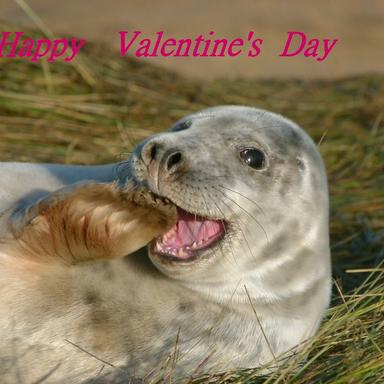

In [18]:
Image.open("imagesorig/happy/6873250907_fd7451e13c_b.jpg")